## Day 24 Lecture 2 Assignment

In this assignment, we will build our a more complex logistic regression model, this time on both numeric and categorical data. We will use the Chicago traffic crashes dataset loaded below and analyze the model generated for this dataset.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

In [3]:
crash_data.head()

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN
0,JC334993,7/4/2019 22:33,45,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC370822,7/30/2019 10:22,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC387098,8/10/2019 17:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC395195,8/16/2019 16:53,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,...,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,JC396604,8/17/2019 16:04,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,PARKING LOT,NaN,...,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0


First, create a binary response column by modifying the "DAMAGE" column. Consider "OVER \\$1500" to be the positive class, and under \\$1500 to be the negative class.

In [3]:
crash_data['is_over_1500'] = crash_data['DAMAGE'] == 'OVER $1,500'
crash_data['is_over_1500'] = crash_data['is_over_1500'].astype(int)

crash_data = crash_data.drop(columns=['DAMAGE'])

crash_data['is_over_1500'].value_counts(normalize=True)

1    0.563418
0    0.436582
Name: is_over_1500, dtype: float64

Using the code from Day 21, Lecture 1 as a starting point, devise an appropriate way to address missing values. You have a lot of freedom here; we will proceed by taking the following steps:

- Dropping all columns with more than 5% missing data
- Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO; imputing it in this manner would not make any sense)
- Dropping rows with missing data for categorical columns that have less than 5% missing data

In [4]:
# Dropping all columns with more than 5% missing data
is_na_perc = crash_data.isna().mean()
drop_cols = is_na_perc[is_na_perc > 0.05].index
crash_data = crash_data.drop(columns=drop_cols)

# Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO)
col_medians = crash_data.drop(columns='STREET_NO').median()
crash_data = crash_data.fillna(col_medians)

# Dropping rows with missing data for categorical columns that have less than 5% missing data
crash_data = crash_data.dropna()

Finally, choose a few numeric and categorical features (2-3 of each) to include in the model. (You can definitely include more than this, but too many features, especially categorical ones, will most likely lead to convergence issues). One hot encode the chosen categorical features, being sure to omit one of the categories (which will serve as a "reference" level) to avoid perfect multicollinearity.

Again, you have a lot of freedom here; we will proceed with the following features, dropping the most commonly occurring category for the two categorical variables ("CLEAR" for weather, "REAR END" for first crash type):
POSTED_SPEED_LIMIT, WEATHER_CONDITION, INJURIES_TOTAL, FIRST_CRASH_TYPE

In [5]:
x_cols = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE']
X = crash_data[x_cols]
y = crash_data['is_over_1500']

In [6]:
# Why does it make sense to drop the most occuring category?
drop_cats = ['WEATHER_CONDITION_CLEAR', 'FIRST_CRASH_TYPE_REAR END']
X_dummies = pd.get_dummies(X)
X_dummies = X_dummies.drop(columns=drop_cats)

Split the data into train and test, with 80% training and 20% testing. By default, the LR output from statsmodels does not include an intercept terms; add a constant column to the training data so that an intercept term is calculated for the LR model (hint: sm.add_constant() is a useful function to accomplish this).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dummies, y, test_size=0.2, random_state=42
)

Fit the logistic regression model using the statsmodels package and print out the coefficient summary. Which variables (in particular, which categories of our categorical variables) appear to be the most important, and what effect do they have on the probability of a crash resulting in $1500 or more in damages?

### `sklearn`

In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
model.score(X_train, y_train)

0.5831109088024939

In [10]:
model.score(X_test, y_test)

0.5857483757948605

In [11]:
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
conf_df

,Predicted 0,Predicted 1
Actual 0,9633,22203
Actual 1,7829,32832


### `statsmodels`

In [12]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

sm_model = sm.Logit(y_train, X_train_const).fit()
print(sm_model.summary())

Optimization terminated successfully.
         Current function value: 0.658184
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           is_over_1500   No. Observations:               289986
Model:                          Logit   Df Residuals:                   289956
Method:                           MLE   Df Model:                           29
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:                 0.03970
Time:                        07:52:33   Log-Likelihood:            -1.9086e+05
converged:                       True   LL-Null:                   -1.9876e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                 

In [13]:
y_pred = sm_model.predict(X_test_const)
y_pred = y_pred > 0.5

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
conf_df

,Predicted 0,Predicted 1
Actual 0,9622,22214
Actual 1,7809,32852


As we did on the previous exercise, make predictions on the test set and join them to the corresponding true outcomes, then use the *calibration_curve* function in scikit learn to plot a calibration curve. Is the model well-calibrated?

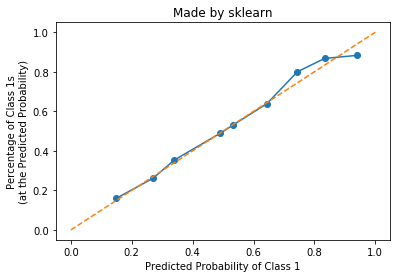

In [14]:
y_pred_prob = model.predict_proba(X_test)[:, 1] # sklearn
# y_pred_prob = sm_model.predict(X_test_const)  # statsmodels

y, x = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.plot(x, y, '-o')
plt.plot([0,1], [0,1], '--')
plt.title('Made by sklearn')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Percentage of Class 1s\n(at the Predicted Probability)')
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_true = y_test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.30      0.39     31836
           1       0.60      0.81      0.69     40661

    accuracy                           0.59     72497
   macro avg       0.57      0.56      0.54     72497
weighted avg       0.58      0.59      0.56     72497

